In [ ]:
pip install tensorflow opencv-python matplotlib


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

# Load pretrained MobileNetV2 (only convolutional base)
base_model = tf.keras.applications.MobileNetV2(weights='imagenet',
                                               include_top=False,
                                               input_shape=(224, 224, 3))
base_model.trainable = False

# Grad-CAM model (outputs both feature maps and final layer)
last_conv_layer_name = 'Conv_1'
grad_model = tf.keras.models.Model(
    inputs=base_model.input,
    outputs=[base_model.get_layer(last_conv_layer_name).output,
             base_model.output]
)

# Function to preprocess image
def preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return img_array, np.array(img) / 255.0  # Return normalized original image for overlay

# Generate Grad-CAM heatmap
def get_gradcam_heatmap(img_array, model, channel_index=None):
    with tf.GradientTape() as tape:
        conv_outputs, _ = model(img_array)
        if channel_index is None:
            channel_index = tf.argmax(tf.reduce_mean(conv_outputs, axis=[1, 2])).numpy()[0] # Extract scalar index
        output = conv_outputs[:, :, :, channel_index]

    grads = tape.gradient(output, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]

    # Weight feature maps by gradients
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8
    return heatmap # Removed .numpy()

# Overlay heatmap on image
def overlay_heatmap(image, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET): # Increased alpha back to 0.4
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), colormap)
    overlayed = cv2.addWeighted(np.uint8(image * 255), 1 - alpha, heatmap_colored, alpha, 0)
    return overlayed

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


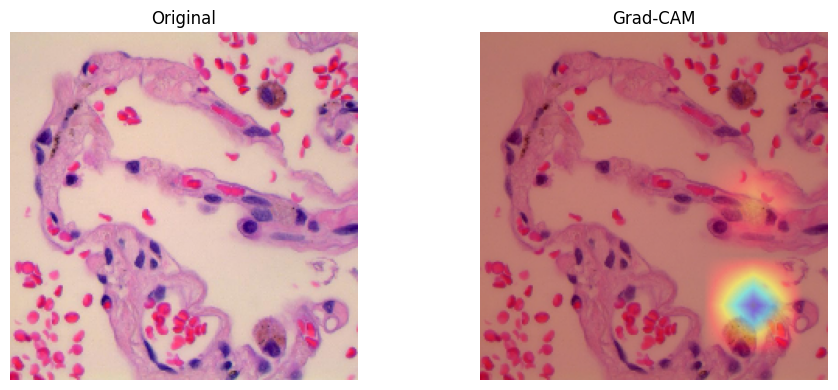

In [ ]:
# Load image
img_path = '/content/drive/MyDrive/Lung_Cancer_Split/train/lung_n/lungn3803.jpeg'  # replace with your actual test image
img_array, original_img = preprocess_image(img_path)

# Generate Grad-CAM
heatmap = get_gradcam_heatmap(img_array, grad_model)

# Overlay
overlayed_img = overlay_heatmap(original_img, heatmap)

# Show
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(original_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(overlayed_img)
plt.axis('off')
plt.tight_layout()
plt.show()


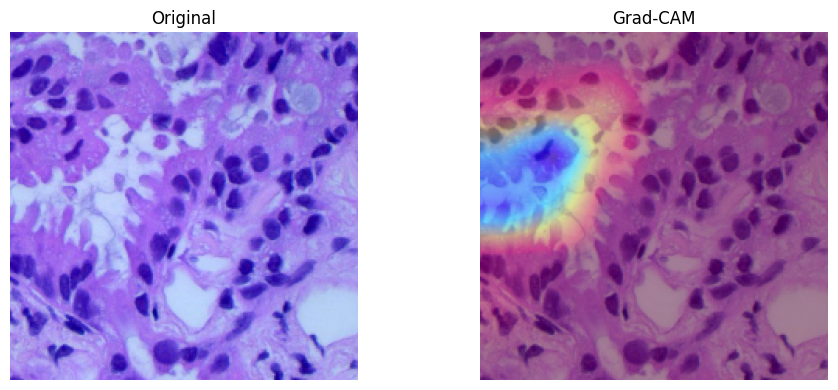

In [ ]:
# Load image
img_path = '/content/drive/MyDrive/Lung_Cancer_Split/train/lung_aca/lungaca1261.jpeg'  # replace with your actual test image
img_array, original_img = preprocess_image(img_path)

# Generate Grad-CAM
heatmap = get_gradcam_heatmap(img_array, grad_model)

# Overlay
overlayed_img = overlay_heatmap(original_img, heatmap)

# Show
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(original_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(overlayed_img)
plt.axis('off')
plt.tight_layout()
plt.show()


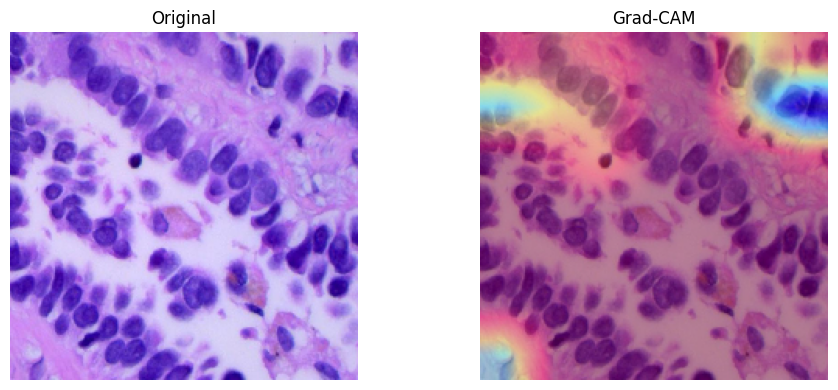

In [ ]:
# Load image
img_path = '/content/drive/MyDrive/Lung_Cancer_Split/train/lung_aca/lungaca2772.jpeg'  # replace with your actual test image
img_array, original_img = preprocess_image(img_path)

# Generate Grad-CAM
heatmap = get_gradcam_heatmap(img_array, grad_model)

# Overlay
overlayed_img = overlay_heatmap(original_img, heatmap)

# Show
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(original_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(overlayed_img)
plt.axis('off')
plt.tight_layout()
plt.show()

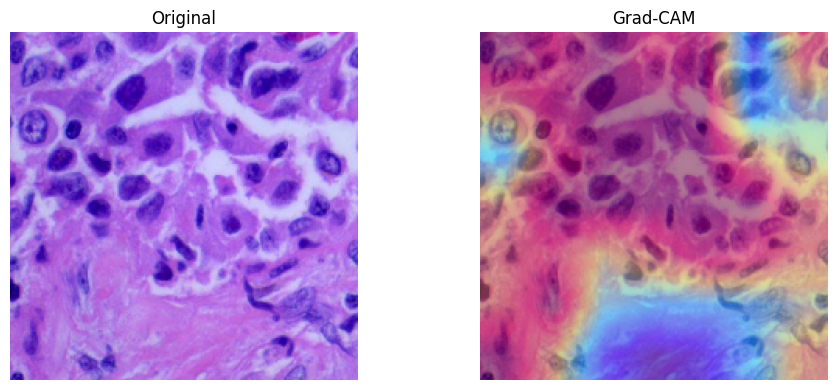

In [ ]:
# Load image
img_path = '/content/drive/MyDrive/Lung_Cancer_Split/train/lung_aca/lungaca2007.jpeg'  # replace with your actual test image
img_array, original_img = preprocess_image(img_path)

# Generate Grad-CAM
heatmap = get_gradcam_heatmap(img_array, grad_model)

# Overlay
overlayed_img = overlay_heatmap(original_img, heatmap)

# Show
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(original_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(overlayed_img)
plt.axis('off')
plt.tight_layout()
plt.show()

# Shap


In [ ]:
# ✅ Step 1: Imports
import xgboost as xgb
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# ✅ Step 2: Mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')


In [ ]:
# ✅ Step 3: Define paths (as per your notebook)
model_path   = "/content/drive/MyDrive/xgboost_hybrid_model.json"
features_path = "/content/drive/MyDrive/mobilenet_features.npy"
labels_path   = "/content/drive/MyDrive/mobilenet_labels.npy"


In [ ]:
# ✅ Step 4: Load model and data
# Load XGBoost Booster
xgb_model = xgb.Booster()
xgb_model.load_model(model_path)

# Load features and labels
X = np.load(features_path)  # shape: (n_samples, 1280)
y = np.load(labels_path)    # e.g., ['LUAD', 'Normal', 'LUSC', ...]

# Encode labels (if needed)
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # for consistency

# Wrap Booster into sklearn API model
xgb_model_sklearn = xgb.XGBClassifier()
xgb_model_sklearn._Booster = xgb_model
xgb_model_sklearn._le = le  # Dummy label encoder


In [ ]:
# ✅ Step 5: Create SHAP Explainer and Compute SHAP Values
explainer = shap.Explainer(xgb_model_sklearn, X)
shap_values = explainer(X)  # Returns a shap.Explanation object


100%|===================| 36005/36024 [10:03<00:00]       

In [ ]:
# ✅ Step 6: Save SHAP values to Google Drive (optional)
np.save('/content/drive/MyDrive/shap_values.npy', shap_values.values)  # shape: (n_samples, n_features, n_classes)


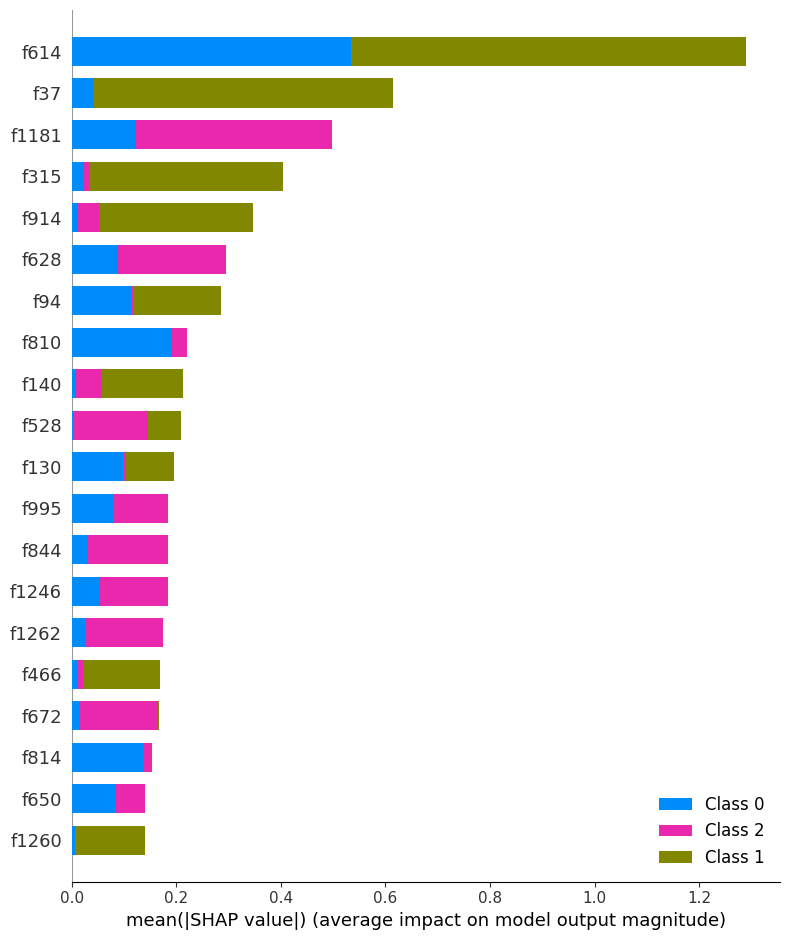

In [ ]:
# ✅ Step 7: Plot SHAP Summary Plot (All Classes Combined)
shap.summary_plot(shap_values, X, feature_names=[f"f{i}" for i in range(X.shape[1])])


In [ ]:
# SHAP values shape: (n_samples, 1280, 3) for 3 classes
shap_array = shap_values.values

# Class order inferred from label encoder:
class_names = le.classes_  # ['LUAD', 'LUSC', 'Normal']
print("Class order:", class_names)


Class order: [0 1 2]


In [ ]:
# 🔹 Example: SHAP values for LUAD (class index 0)
shap_luad = shap_array[:, :, 0]

# 🔹 For LUSC and Normal:
shap_lusc = shap_array[:, :, 1]
shap_normal = shap_array[:, :, 2]


# Shap + GradCam


In [ ]:
import tensorflow as tf

# Load base MobileNetV2 model
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model.trainable = False

# Create model to extract from 'Conv_1' layer
grad_model = tf.keras.models.Model(
    inputs=base_model.input,
    outputs=base_model.get_layer("Conv_1").output  # shape: (7, 7, 1280)
)


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

def load_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img

# Replace with the image path you're using
img_path ='/content/drive/MyDrive/Lung_Cancer_Split/train/lung_n/lungn3803.jpeg'
img_array, original_img = load_image(img_path)
preprocessed = preprocess_input(np.copy(img_array))  # Don't alter original


In [ ]:
# Get Conv_1 feature map
conv_output = grad_model.predict(preprocessed)  # shape: (1, 7, 7, 1280)
conv_output = conv_output[0]  # Remove batch dimension → (7, 7, 1280)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


In [ ]:
# Use same index as the image used
sample_idx = 0

# Load your saved SHAP values (from npy)
shap_values = np.load('/content/drive/MyDrive/shap_values.npy')  # shape: (n_samples, 1280, 3)

# Get class-predicted SHAP values (e.g., LUAD = 0, LUSC = 1, Normal = 2)
predicted_class_idx = 0  # or get dynamically from xgb_model.predict()
shap_vector = shap_values[sample_idx, :, predicted_class_idx]  # shape: (1280,)


In [ ]:
# Normalize SHAP values (optional)
shap_weights = shap_vector / (np.linalg.norm(shap_vector) + 1e-8)

# Weighted sum of feature maps
heatmap = np.tensordot(conv_output, shap_weights, axes=([2], [0]))  # (7, 7)
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap) + 1e-8


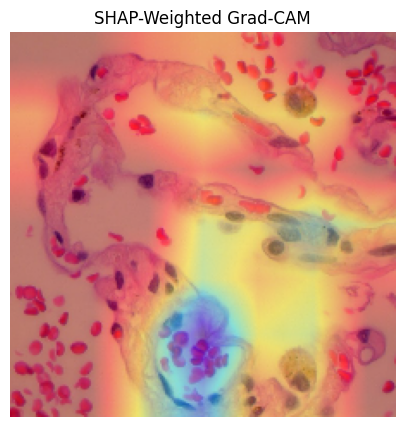

In [ ]:
import cv2
import matplotlib.pyplot as plt

def overlay_heatmap_on_image(img, heatmap, alpha=0.4):
    heatmap_resized = cv2.resize(heatmap, (img.size[0], img.size[1]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(np.array(img).astype(np.uint8), 1 - alpha, heatmap_color, alpha, 0)
    return overlay

overlayed_img = overlay_heatmap_on_image(original_img, heatmap)

# Display
plt.figure(figsize=(10, 5))
plt.imshow(overlayed_img)
plt.title("SHAP-Weighted Grad-CAM")
plt.axis("off")
plt.show()
